La eliminación de GAUSS para sistemas tridiagonales:

In [5]:
import numpy as np

def tripiv(a, b, c, d):
  """
    Argumentos:
        a: diagonal inferior (a[0] no se usa)
        b: diagonal principal
        c: diagonal superior (c[-1] no se usa)
        d: lado derecho del sistema Ay=x
    Returns:
        x: solución

    """
  n = len(b)
  x = np.zeros(n)
  fail = 0

  # reordenamiento

  a[0] = b[0]
  b[0] = c[0]
  c[0] = 0

  # eliminación:

  l = 0

  for k in range(0,n):
      q = a[k]
      i = k

      if l < n-1:
          l = l + 1

      for j in range(k+1,l+1):
          q1 = a[j]
          if (np.abs(q1) > np.abs(q)):
              q = q1
              i = j
      if q == 0:
          fail = -1

      if i != k:
          q = d[k]
          d[k] = d[i]
          d[i] = q
          q = a[k]
          a[k] = a[i]
          a[i] = q
          q = b[k]
          b[k] = b[i]
          b[i] = q
          q = c[k]
          c[k] =c[i]
          c[i] = q
      for i in range(k+1,l+1):
          q = a[i]/a[k]
          d[i] = d[i]-q*d[k]
          a[i] = b[i]-q*b[k]
          b[i] = c[i]-q*c[k]
          c[i] = 0



    # sustitución

  x[n-1] = d[n-1]/a[n-1]
  x[n-2] = (d[n-2]-b[n-2]*x[n-1])/a[n-2]

  for i in range(n-3,-1,-1):

      q = d[i] - b[i]*x[i+1]
      x[i] = (q - c[i]*x[i+2])/a[i]

  return x

La fución cspline del libro, usando la eliminación de Gauss escrita arriba, lo comentado es del libro pero no funciona y da el mismo resultado que mi función.

In [139]:
import numpy as np

def cspline(knots,data,x):
  """
  """
  N = np.size(knots-1)
  P = np.size(x)
  h = np.diff(knots)
  D = np.diff(data)/h
  dD3 = 3*np.diff(D)
  a = data[:N]

  # Generar las diagonales de la matriz A
  """
  H = (np.diag(2*(h[:-1]+h[1:]))+np.diag(h[1:-1],1)+np.diag(h[1:-1],-1))
  #print(H)
  """

  A1 = [0]
  A2 = 2*(h[:-1]+h[1:])
  A3 = h[1:-1]
  #for i in range (1,N-2):
   # A1.append(h[i])
    #A3.append(h[i])
  A1 = np.append(A1,A3)
  A3 = np.append(A3,0)
  c = np.zeros(N)
  c[1:N-1]=np.array(tripiv(A1,A2,A3,dD3))
  b = D-h*(c[1:]+2*c[:-1])/3
  d = (c[1:]-c[:1])/(3*h)

  """
  c = np.zeros(N)
  c[1:N-1]=np.linalg.solve(H,dD3)
  b = D-h*(c[1:]+2*c[:-1])/3
  d = (c[1:]-c[:1])/(3*h)
  """
  # Evaluar el spline en x
  s = np.empty(P)
  for i in range(P):
    indices = np.argwhere(x[i]>knots)
    if indices.size>0:
      k = indices.flat[-1]
    elif x[i] == knots[0]:
      k = 0
    else:
      raise ValueError('cspline no da puntos afuera del intervalo de los nodos')
    z=x[i]-knots[k]
    s[i]=a[k]+z*(b[k]+z*(c[k]+z*d[k]))
  return s

Implementación (fallida) función raíz cuadrada y función sin^2

<function matplotlib.pyplot.show(close=None, block=None)>

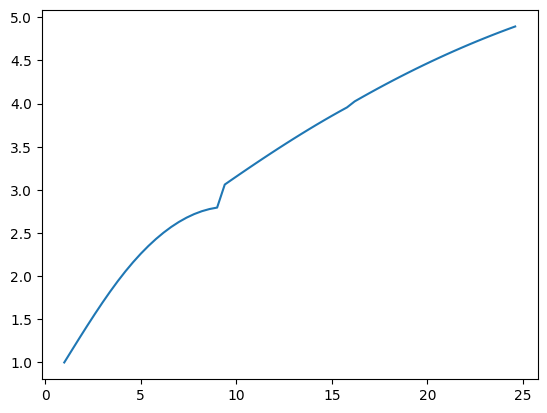

In [140]:
from matplotlib import pyplot as plt
X = np.array([1 , 4 , 9 , 16 , 25])
Y = np.array([1 , 2 , 3 , 4 , 5])
x = np.arange(1,25,.4)
y = cspline(X,Y,x)
plt.plot(x,y)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

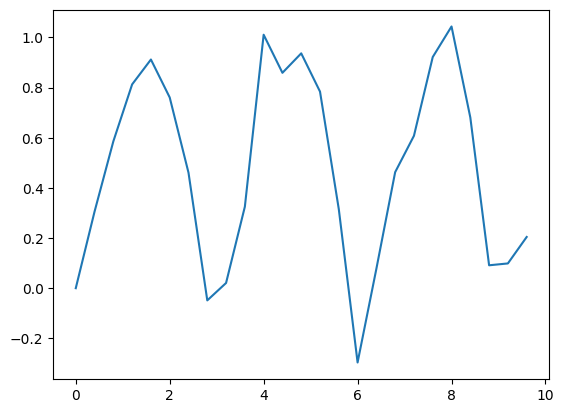

In [142]:
X = np.linspace(0, 10, 11)
Y = np.sin(x4)**2
x = np.arange(0,10,.4)
y = cspline(X,Y,x)
plt.plot(x,y)
plt.show

Función nueva que sí funciona para interpolar

In [133]:
def cubic_interp1d(x0, x, y):

    x = np.asfarray(x)
    y = np.asfarray(y)

    if np.any(np.diff(x) < 0):
        indexes = np.argsort(x)
        x = x[indexes]
        y = y[indexes]

    size = len(x)

    xdiff = np.diff(x)
    ydiff = np.diff(y)

    Li = np.empty(size)
    Li_1 = np.empty(size-1)
    z = np.empty(size)


    Li[0] = np.sqrt(2*xdiff[0])
    Li_1[0] = 0.0
    B0 = 0.0
    z[0] = B0 / Li[0]

    for i in range(1, size-1, 1):
        Li_1[i] = xdiff[i-1] / Li[i-1]
        Li[i] = np.sqrt(2*(xdiff[i-1]+xdiff[i]) - Li_1[i-1] * Li_1[i-1])
        Bi = 6*(ydiff[i]/xdiff[i] - ydiff[i-1]/xdiff[i-1])
        z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    i = size - 1
    Li_1[i-1] = xdiff[-1] / Li[i-1]
    Li[i] = np.sqrt(2*xdiff[-1] - Li_1[i-1] * Li_1[i-1])
    Bi = 0.0
    z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    i = size-1
    z[i] = z[i] / Li[i]
    for i in range(size-2, -1, -1):
        z[i] = (z[i] - Li_1[i-1]*z[i+1])/Li[i]

    index = x.searchsorted(x0)
    np.clip(index, 1, size-1, index)

    xi1, xi0 = x[index], x[index-1]
    yi1, yi0 = y[index], y[index-1]
    zi1, zi0 = z[index], z[index-1]
    hi1 = xi1 - xi0

    f0 = zi0/(6*hi1)*(xi1-x0)**3 + \
         zi1/(6*hi1)*(x0-xi0)**3 + \
         (yi1/hi1 - zi1*hi1/6)*(x0-xi0) + \
         (yi0/hi1 - zi0*hi1/6)*(xi1-x0)
    return f0

Ejemplo con sin^2

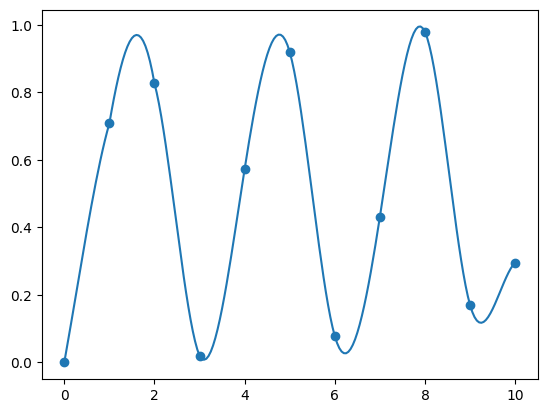

In [143]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    x4 = np.linspace(0, 10, 11)
    y4 = np.sin(x4)**2
    plt.scatter(x4, y4)

    x_new = np.linspace(0, 10, 201)
    plt.plot(x_new, cubic_interp1d(x_new, x4, y4))

    plt.show()

Usando CubicSpline para un conjunto de datos en 2D que forman la letra D en manuscrita 😃

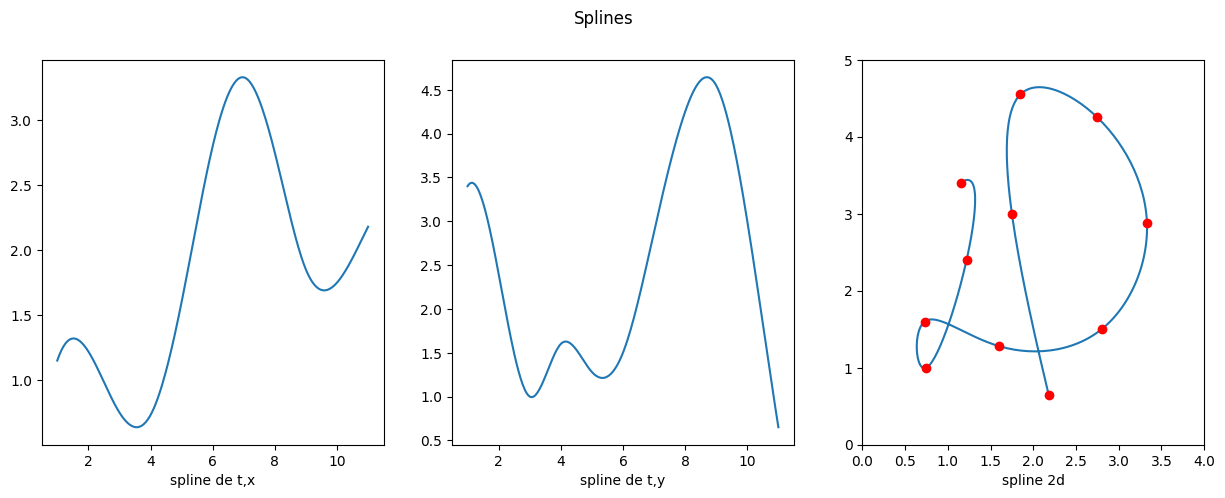

In [163]:
from scipy.interpolate import CubicSpline
t=[i for i in range (1,12)]
x=[1.15,1.22,0.75,0.73,1.6,2.8,3.33,2.75,1.85,1.75,2.18]
y=[3.4,2.4,1,1.6,1.28,1.5,2.88,4.25,4.55,3,0.65]

csx = CubicSpline(t,x)
csy = CubicSpline(t,y)

T=np.linspace(1,11,300)
"""
plt.plot(csx(T),csy(T))
plt.axis((0, 4, 0, 5))
plt.show()
"""
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
fig.suptitle('Splines')


ax1.plot(T, csx(T))
ax1.set_xlabel('spline de t,x')

ax2.plot(T,csy(T))
ax2.set_xlabel('spline de t,y')

ax3.plot(csx(T),csy(T))
ax3.plot(x,y,'ro') #los puntos rojos son los puntos de interpolación
ax3.set_xlabel('spline 2d')
ax3.axis((0,4,0,5))

plt.show()